In [1]:
import pandas as pd
import pyarrow
from datetime import datetime, timedelta
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

**Importing Datasets**

Original 'dirty' datasets retrieved from AWS s3 bucket and aed dataset with geocoded addresses retrieved from public GitHub Repository (takes 1336s to run this data retrieval)

In [2]:
url = 's3://mdaprojectdata2/'
url2 = 'https://raw.githubusercontent.com/JeroenGuillierme/Project-MDA/main/Data/'

ambulance = pd.read_parquet(f'{url}ambulance_locations.parquet.gzip')
mug = pd.read_parquet(f'{url}mug_locations.parquet.gzip')
pit = pd.read_parquet(f'{url}pit_locations.parquet.gzip')
interventions1 = pd.read_parquet(f'{url}interventions1.parquet.gzip')
interventions2 = pd.read_parquet(f'{url}interventions2.parquet.gzip')
interventions3 = pd.read_parquet(f'{url}interventions3.parquet.gzip')
interventions4 = pd.read_parquet(f'{url}interventions_bxl.parquet.gzip')
interventions5 = pd.read_parquet(f'{url}interventions_bxl2.parquet.gzip')
cad = pd.read_parquet(f'{url}cad9.parquet.gzip')
aed = pd.read_parquet(f'{url}aed_locations.parquet.gzip')

aed_total = pd.read_csv(f'{url2}aed_total_coordinates.csv')
mug1 = pd.read_csv(f'{url2}mug1.csv')

pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

**Functions**

Here some functions are defined, which will be used further in this Notebook for preprocessing/cleaning the data.

In [3]:
# Function to correct latitude values
def correct_latitude(lat):
    '''
    Corrects and standardizes latitude values by ensuring they are numeric and properly formatted.
    :param lat: str, float or int
    The latitude value to be corrected.
    :return: float
    The corrected latitude value, or NaN if the input is NaN.
    '''
    if pd.isna(lat):
        return lat  # Return NaN as it is
    if isinstance(lat, (str, float, int)):
        lat_str = str(lat)
        # Remove any existing non-numeric characters (except -)
        lat_str = re.sub(r'[^0-9-]', '', lat_str)
        # Move the decimal point to ensure two digits before the decimal point
        if len(lat_str) > 2:
            lat_str = lat_str[:2] + '.' + lat_str[2:]
        return float(lat_str)
    return lat


# Function to correct longitude values
def correct_longitude(lon):
    '''
    Corrects and standardizes longitude values by ensuring they are numeric and properly formatted.
    :param lon: str, float or int
    The longitude value to be corrected.
    :return:float
    The corrected longitude value, or NaN if the input is NaN.
    '''
    if pd.isna(lon):
        return lon  # Return NaN as it is
    if isinstance(lon, (str, float, int)):
        lon_str = str(lon)
        # Remove any existing non-numeric characters (except -)
        lon_str = re.sub(r'[^0-9-]', '', lon_str)
        # Move the decimal point to ensure one digit before the decimal point
        if len(lon_str) > 1:
            lon_str = lon_str[:1] + '.' + lon_str[1:]
        return float(lon_str)
    return lon


# Define a function to extract the numeric part using regex
def extract_numeric(text):
    '''
    Extracts the first numeric part from a given text using regular expressions.
    :param text: str
    The text from which to extract the numeric part.
    :return: int or float
    The extracted numeric value, or NaN if no numeric part is found.
    '''
    match = re.search(r'\d+', text)
    return int(match.group()) if match else np.nan


# Function to filter rows based on coordinates falling within Belgium
def is_within_belgium(lat, lon):
    '''
    Checks if given latitude and longitude coordinates fall within Belgium's geographical boundaries.
    :param lat: float
    The latitude value to be checked.
    :param lon: float
    The longitude value to be checked.
    :return: bool
    True if the coordinates are within Belgium's boundaries, False otherwise.
    '''
    # Define the geographical boundaries of Belgium
    belgium_boundaries = {
        'min_latitude': 49.50,
        'max_latitude': 51.50,
        'min_longitude': 2.5,
        'max_longitude': 6.5
    }

    return (belgium_boundaries['min_latitude'] <= lat <= belgium_boundaries['max_latitude']) and \
        (belgium_boundaries['min_longitude'] <= lon <= belgium_boundaries['max_longitude'])

# Function to convert time formats like %d%b%y:%H:%M:%S to date time
def convert_format1(time1):
    return pd.to_datetime(time1, format='%d%b%y:%H:%M:%S')

# Function to convert time formats like %Y-%m-%d %H:%M:%S.%f to date time
def convert_format2(time2):
    return pd.to_datetime(time2, format='%Y-%m-%d %H:%M:%S.%f')

# Function to convert time formats like %Y-%m-%d %H:%M:%S.%f %z to date time
def convert_format3(time3):
    return pd.to_datetime(time3, format='%Y-%m-%d %H:%M:%S.%f %z', dayfirst=True)


# Function to convert Timedelta to minutes
def timedelta_to_minutes(td):
    '''
    Converts a pandas Timedelta object to minutes.
    :param td: pd.TimeDelta
    The Timedelta object to be converted.
    :return: float
    The total duration in minutes.
    '''
    return td.total_seconds() / 60

# Setting the style for the plots
sns.set(style="whitegrid")

# Function to draw histograms
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.histplot(df[var_name], bins=100, ax=ax).set(title=var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

**Preprocessing Interventions Datasets**

**Starting with first three intervention datasets**

In [4]:
# only keeping cardiac arrest interventions
interventions1 = interventions1[interventions1["EventType Firstcall"] == "P003 - Cardiac arrest"]
interventions2 = interventions2[interventions2["EventType Firstcall"] == "P003 - Cardiac arrest"]
interventions3 = interventions3[interventions3["EventType Firstcall"] == "P003 - Cardiac arrest"]

In [5]:
# Converting time formats to datetime 
# T0
interventions1["T0"] = interventions1["T0"].apply(convert_format1)
interventions2["T0"] = interventions2["T0"].apply(convert_format1)
interventions3["T0"] = interventions3["T0"].apply(convert_format1)

# T3
interventions1["T3"] = interventions1["T3"].apply(convert_format2)
interventions2["T3"] = interventions2["T3"].apply(convert_format2)
interventions3["T3"] = interventions3["T3"].apply(convert_format2)


In [6]:
# Concatenating first three intervention datasets
interventions123_total = pd.concat([interventions1, interventions2, interventions3], axis=0)

# Creating response time variable T3-T0, after converting them in the right date-time format
interventions123_total["T3-T0"] = interventions123_total["T3"] - interventions123_total["T0"]

# Renaming variable EventType
interventions123_total['EventType'] = interventions123_total['EventType Firstcall']

# Correcting coordinates
interventions123_total['Latitude'] = interventions123_total['Latitude intervention'].apply(correct_latitude).copy()
interventions123_total['Longitude'] = interventions123_total['Longitude intervention'].apply(correct_longitude).copy()

# Renaming variable Eventlevel
interventions123_total['Eventlevel'] = interventions123_total["EventLevel Firstcall"].copy()
interventions123_total['Intervention'] = 1

# Only keep several variables
interventions123_total = interventions123_total[
    ['Latitude', 'Longitude', "Intervention", "Eventlevel", "T3-T0", "EventType"]]

In [7]:
interventions123_total.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType
42,51.20685,5.13662,1,N1,0 days 00:18:53.095000,P003 - Cardiac arrest
87,51.24848,4.43869,1,N1,0 days 00:04:14.322000,P003 - Cardiac arrest
88,51.24848,4.43869,1,N1,0 days 00:12:36.753000,P003 - Cardiac arrest
207,51.28273,4.42134,1,N1,0 days 00:13:25.674000,P003 - Cardiac arrest
208,51.28273,4.42134,1,N1,0 days 00:36:37.170000,P003 - Cardiac arrest


**Continuing with cad dataset**

In [8]:
# Only keep cardiac arrest incidents
cad = cad[cad['EventType Trip'] == "P003 - HARTSTILSTAND - DOOD - OVERLEDEN"]

In [9]:
# Converting time formats to datetime 
# T0
cad["T0"] = cad["T0"].apply(convert_format2)
# T3
cad["T3"] = cad["T3"].apply(convert_format2)

In [10]:
# Create extra column Intervention
cad['Intervention'] = 1 

# Creating new variable response time T3-T0, after converting them in the right date-time format
cad['T3-T0'] = cad['T3'] - cad['T0']

# Renaming variable EventType
cad['EventType'] = cad['EventType Trip']

# Renaming variable EventLevel
cad['Eventlevel'] = cad['EventLevel Trip']

# Correcting coordinates
cad['Latitude'] = cad['Latitude intervention'].apply(correct_latitude)
cad['Longitude'] = cad['Longitude intervention'].apply(correct_longitude)

# Only keep several variables
cad = cad[['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType']]

In [11]:
cad.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType
322,50.928019,4.535123,1,N1,-44 days +22:49:37,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
323,50.928019,4.535123,1,N1,-44 days +22:49:37,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
440,50.767029,4.273000,1,N1,0 days 00:09:50,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
441,50.767029,4.273000,1,N1,0 days 00:09:50,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
516,50.898349,4.755029,1,N1,0 days 00:15:03,P003 - HARTSTILSTAND - DOOD - OVERLEDEN


**Next, datasets with interventions from Brussels**

In [12]:
# Only keeping interventions for cardiac arrests
interventions4 = interventions4[interventions4['eventtype_firstcall'] == 'P003 - Cardiac arrest']
interventions5 = interventions5[
    (interventions5['EventType and EventLevel'] == 'P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN') | (
            interventions5['EventType and EventLevel'] == 'P003  N05 - HARTSTILSTAND - DOOD - OVERLEDEN')]

In [13]:
# Converting time formats to datetime 
# T0
interventions4["t0"] = interventions4["t0"].apply(convert_format3)
interventions5["T0"] = interventions5["T0"].apply(convert_format1)
# T3
interventions4["t3"] = interventions4["t3"].apply(convert_format3)
interventions5["T3"] = interventions5["T3"].apply(convert_format1)

In [14]:
# Creating variable Intervention
interventions4['Intervention'] = 1
interventions5['Intervention'] = 1

# renaming variable EventType
interventions4['EventType'] = interventions4['eventtype_firstcall']
interventions5['EventType'] = interventions5['EventType and EventLevel'].apply(lambda x: re.sub(r'  [A-Z]\d{2}', '', x))
# Renaming variable Eventlevel
interventions4['Eventlevel'] = interventions4['eventLevel_firstcall']
interventions5["Eventlevel"] = interventions5["EventType and EventLevel"].str.split(" ").str[2].str.replace("0", "")

# Creating variable Response Time T3-T0
interventions4['T3-T0'] = interventions4['t3'] - interventions4['t0']
interventions5['T3-T0'] = interventions5['T3'] - interventions5['T0']

# Correcting coordinates
interventions4['Latitude'] = interventions4['latitude_intervention'].apply(correct_latitude)
interventions4['Longitude'] = interventions4['longitude_intervention'].apply(correct_longitude)
interventions5['Latitude'] = interventions5['Latitude intervention'].apply(correct_latitude)
interventions5['Longitude'] = interventions5['Longitude intervention'].apply(correct_longitude)

# Only keeping several variables
interventions4 = interventions4[['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType']]
interventions5 = interventions5[['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType']]
                                 

C:\Users\Admin\AppData\Local\Temp\ipykernel_1704\610097005.py:13: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  interventions4['T3-T0'] = interventions4['t3'] - interventions4['t0']


In [15]:
interventions4.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType
205,50.83808,4.30484,1,N1,NaT,P003 - Cardiac arrest
206,50.83808,4.30484,1,N1,0 days 00:12:56.619802,P003 - Cardiac arrest
207,50.83808,4.30484,1,N1,NaT,P003 - Cardiac arrest
316,50.82480,4.38185,1,N1,0 days 00:06:09.825415800,P003 - Cardiac arrest
317,50.82480,4.38185,1,N1,0 days 00:08:43.201778800,P003 - Cardiac arrest


In [16]:
interventions5.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType
808,50.849492,4.398207,1,N1,NaT,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
809,50.849492,4.398207,1,N1,NaT,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
1074,50.843201,4.343397,1,N1,0 days 00:08:00,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
1075,50.843201,4.343397,1,N1,NaT,P003 - HARTSTILSTAND - DOOD - OVERLEDEN
1622,50.881461,4.347456,1,N1,NaT,P003 - HARTSTILSTAND - DOOD - OVERLEDEN


**Concatenating everything together**

In [17]:
interventions_TOTAL = pd.concat([interventions123_total, cad, interventions4, interventions5], axis=0)

# Adding extra AED column
interventions_TOTAL['AED'] = 0  

# Extracting numeric part from variable Eventlevel
interventions_TOTAL['Eventlevel'] = interventions_TOTAL['Eventlevel'].apply(extract_numeric)

# Converting timedelta to minutes
interventions_TOTAL['T3-T0'] = interventions_TOTAL['T3-T0'].apply(timedelta_to_minutes)

# Creating new columns for distance calculations later on
interventions_TOTAL['Ambulance'] = 0
interventions_TOTAL['Mug'] = 0

In [18]:
interventions_TOTAL.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug
42,51.20685,5.13662,1,1,18.884917,P003 - Cardiac arrest,0,0,0
87,51.24848,4.43869,1,1,4.238700,P003 - Cardiac arrest,0,0,0
88,51.24848,4.43869,1,1,12.612550,P003 - Cardiac arrest,0,0,0
207,51.28273,4.42134,1,1,13.427900,P003 - Cardiac arrest,0,0,0
208,51.28273,4.42134,1,1,36.619500,P003 - Cardiac arrest,0,0,0


In [19]:
print('Number of NaNs for Response Time: ', len(interventions_TOTAL[interventions_TOTAL['T3-T0'].isna()]))
print('Number of total known Response Times: ', len(interventions_TOTAL['T3-T0']) - len(interventions_TOTAL[interventions_TOTAL['T3-T0'].isna()]))

Number of NaNs for Response Time:  3133
Number of total known Response Times:  10388


**Preprocessing AED Datasets**

In [20]:
# Discard non-public aed locations and also those of which no data is available
yes_values = ['Y', 'y', 'Oui-Ja', 'Ja', 'Oui', 'J', np.nan]
aed_total = aed_total[
    aed_total['public'].isin(yes_values)]  

# Correcting coordinates
aed_total['Latitude'] = aed_total['latitude'].apply(correct_latitude)
aed_total['Longitude'] = aed_total['longitude'].apply(correct_longitude)

# Creatin new variables Intervention, AED, Ambulance, Mug, T3-T0, EventType and EventLevel
aed_total['Intervention'] = 0
aed_total['AED'] = 1
aed_total['Eventlevel'] = np.nan
aed_total['EventType'] = 'AED'
aed_total['T3-T0'] = pd.NaT
aed_total['Ambulance'] = 0
aed_total['Mug'] = 0

# Select only several variables for further analysis
aed_total = aed_total[
    ['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 'AED', 'Ambulance', 'Mug']]

**Preprocessing Ambulance Dataset**

In [21]:
# Correcting coordinates
ambulance['Latitude'] = ambulance['latitude'].apply(correct_latitude)
ambulance['Longitude'] = ambulance['longitude'].apply(correct_longitude)

# Creating new variables Intervention, AED, Eventlevel, EventType, T3-T0, Ambulance and Mug
ambulance['Intervention'] = 0
ambulance['AED'] = 0
ambulance['Eventlevel'] = np.nan
ambulance['EventType'] = 'Ambulance'
ambulance['T3-T0'] = pd.NaT
ambulance['Ambulance'] = 1
ambulance['Mug'] = 0
ambulance = ambulance[
    ['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 'AED', 'Ambulance', 'Mug']]

In [22]:
ambulance.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug
0,51.215516,4.443788,0,NaN,NaT,Ambulance,0,1,0
1,51.178831,4.361948,0,NaN,NaT,Ambulance,0,1,0
2,51.232810,4.377237,0,NaN,NaT,Ambulance,0,1,0
3,51.315516,4.321506,0,NaN,NaT,Ambulance,0,1,0
4,51.213623,4.405718,0,NaN,NaT,Ambulance,0,1,0


**Preprocessing Mug Dataset**

In [23]:
# Correcting coordinates
mug1['Latitude'] = mug1['latitude'].apply(correct_latitude)
mug1['Longitude'] = mug1['longitude'].apply(correct_longitude)

# Creating new variables Intervention, AED, Eventlevel, EventType, T3-T0, Ambulance and Mug
mug1['Intervention'] = 0
mug1['AED'] = 0
mug1['Eventlevel'] = np.nan
mug1['EventType'] = 'Mug'
mug1['T3-T0'] = pd.NaT
mug1['Ambulance'] = 1
mug1['Mug'] = 1
mug1 = mug1[['Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 'AED', 'Ambulance', 'Mug']]

In [24]:
mug1.head(5)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug
0,51.133301,5.162843,0,NaN,NaT,Mug,0,1,1
1,51.206704,4.414373,0,NaN,NaT,Mug,0,1,1
2,51.206492,4.470635,0,NaN,NaT,Mug,0,1,1
3,51.182009,4.420858,0,NaN,NaT,Mug,0,1,1
4,51.175704,4.412289,0,NaN,NaT,Mug,0,1,1


**Concatenating all together for AED optimization**

In [25]:
aed_df = pd.concat([interventions_TOTAL, aed_total, ambulance, mug1], axis=0)

In [26]:
print('Unique number of values Latitude values: ', len(list(aed_df['Latitude'].unique())))
print('Unique number of values Longitude values: ', len(list(aed_df['Longitude'].unique())))
print('Unique values eventlevels', aed_df['Eventlevel'].unique())
cross_tab = pd.crosstab(index=pd.Categorical(aed_df["Eventlevel"]), columns='count')
print('Cross table of Event Levels: \n', cross_tab)

max_responseTime = aed_df['T3-T0'].max()
print(f"Maximum Response Time for aed_df: {max_responseTime}")

Unique number of values Latitude values:  18092
Unique number of values Longitude values:  18727
Unique values eventlevels [ 1.  2.  0.  5.  7.  6. nan]
Cross table of Event Levels: 
 col_0  count
row_0       
0.0     1920
1.0     9749
2.0      747
5.0     1030
6.0       69
7.0        6
Maximum Response Time for aed_df: 80267.83333333333


**Graphical inspection of the parameters**

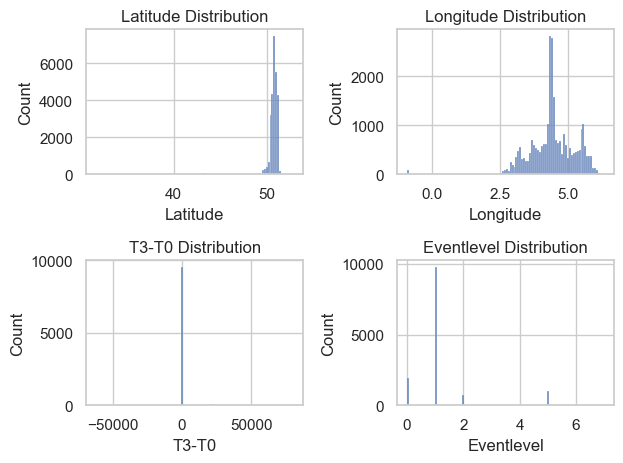

In [27]:
# Setting the style for the plots
sns.set(style="whitegrid")
draw_histograms(aed_df, aed_df[['Latitude', 'Longitude', 'T3-T0', 'Eventlevel']], 2, 2)

[Text(0.5, 1.0, 'Logscale of Response Times'), Text(0.5, 0, 'Log(T3-T0)')]

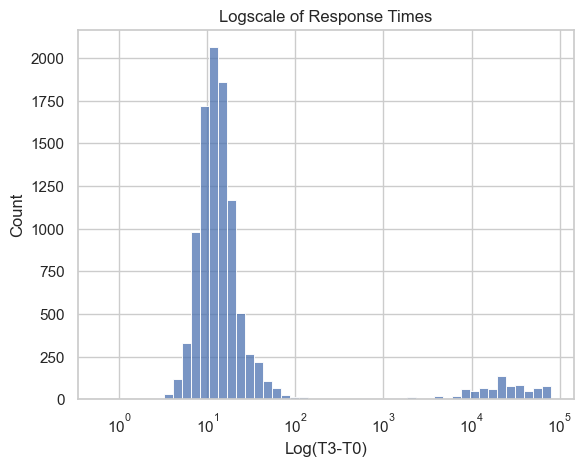

In [28]:
# Setting the style for the plots
sns.set(style="whitegrid")
sns.histplot(aed_df['T3-T0'], bins=50, log_scale=True).set(title='Logscale of Response Times', xlabel='Log(T3-T0)')

[Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude'),
 Text(0.5, 1.0, 'Coordinate pairs in dataset')]

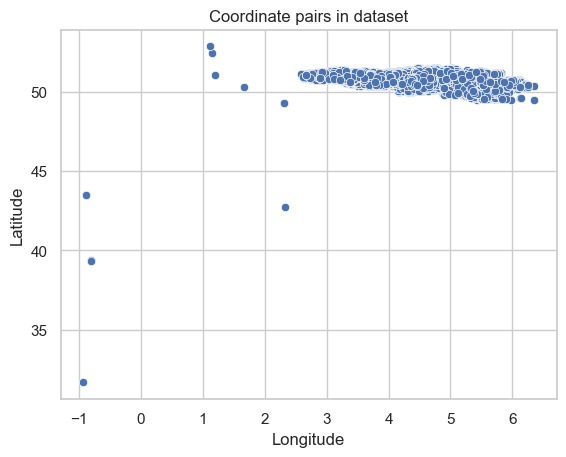

In [29]:
coordinates = aed_df[['Longitude', 'Latitude']]
coordinates.reset_index(drop=True, inplace=True) # Indices must be reset, because there were duplicates present
sns.scatterplot(data=coordinates, x='Longitude', y='Latitude').set(xlabel='Longitude', ylabel='Latitude', title='Coordinate pairs in dataset')

**Remove coordinate pairs which does not lie in Belgium and set negative response times to pd.NaT**

Belgian coordinates found from source: https://www.belgium.be/en/about_belgium/country/geography 

Citate: 'Belgium spans 2 degrees in latitude, from 51 degrees 30 minutes N at Meerle (northernmost point) to 49 degrees 30 minutes N at Torgny (southernmost point). In longitude, it spans less than 4 degrees, from 2 degrees 33 minutes E to 6 degrees 24 minutes E.'

In [30]:
# Remove locations outside of Belgium from the dataset
aed_df = aed_df[aed_df.apply(lambda row: is_within_belgium(row['Latitude'], row['Longitude']), axis=1)]

# Transform negative time difference to NaT
aed_df.loc[aed_df['T3-T0'] < 0, 'T3-T0'] = pd.NaT

[Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude'),
 Text(0.5, 1.0, 'Coordinate pairs in dataset')]

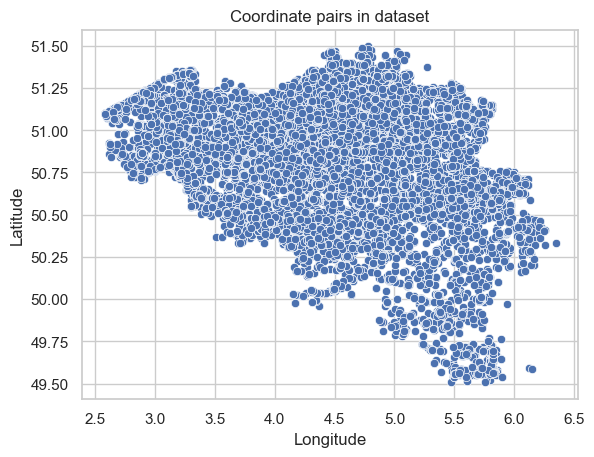

In [31]:
coordinates = aed_df[['Longitude', 'Latitude']]
coordinates.reset_index(drop=True, inplace=True) # Indices must be reset, because there were duplicates present
sns.scatterplot(data=coordinates, x='Longitude', y='Latitude').set(xlabel='Longitude', ylabel='Latitude', title='Coordinate pairs in dataset')

[Text(0.5, 1.0, 'Logscale of Response Times'), Text(0.5, 0, 'Log(T3-T0)')]

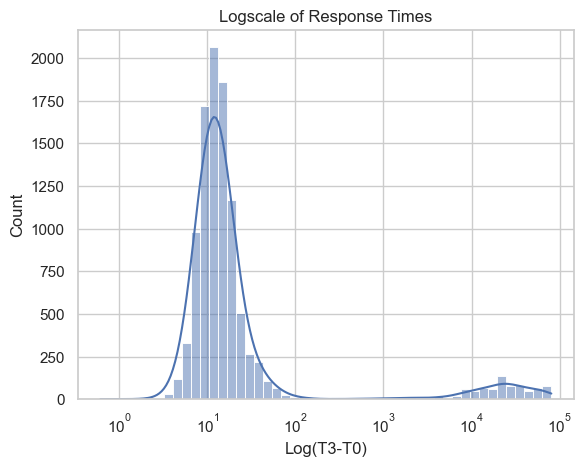

In [32]:
# Histogram of Response Time distribution
sns.histplot(data=aed_df['T3-T0'], bins=50, log_scale=True, kde=True).set(title='Logscale of Response Times', xlabel='Log(T3-T0)') 
# Seriously long Response times found. Seems there is a group of outliers.

**Outlier Detection for Response Time T3-T0**

IsolationForest (for outliers/anomalies of the response time T3-T0, because some are longer than 1 day)
=> probably incorrectly filled in, in the dataset


In [33]:
print(aed_df['T3-T0'].isna().sum())  # 16233 NaN values

16233


In [34]:
# Split the DataFrame into two: one with the NaN and one without in the 'T3-T0' column
# DataFrame with NaN values
aed_df_with_nan = aed_df[aed_df['T3-T0'].isna()]  
# DataFrame without NaN values
aed_df_without_nan = aed_df[~aed_df['T3-T0'].isna()]  

print('Without NaN: ', len(aed_df_without_nan))
print('With NaN: ', len(aed_df_with_nan))

Without NaN:  10343
With NaN:  16233


In [35]:
Time = aed_df_without_nan['T3-T0']

# IsolationForest algorithm
IsoFo = IsolationForest(n_estimators=100, contamination='auto',
                        random_state=45)  # Random state added for reproducibility
y_labels = IsoFo.fit_predict(np.array(Time).reshape(-1, 1))

# Only including the inliers
aed_df_filtered = aed_df_without_nan[y_labels == 1]  # DataFrame with inliers
discarded_rows = aed_df_without_nan[y_labels == -1]  # DataFrame with outliers

min_timedelta = discarded_rows['T3-T0'].min()  # Time deltas larger than 44.27 minutes are discarded
max_timedelta = discarded_rows['T3-T0'].max()
min_timedelta2 = aed_df_filtered['T3-T0'].min()
max_timedelta2 = aed_df_filtered['T3-T0'].max()
print(f"min response time of outliers: {min_timedelta}")  # Minimum outlier value = 44.27 minutes
print(f"max response time of outliers: {max_timedelta}")  # Maximum outlier value = 80267.83 minutes
print(f"min response time of inliers: {min_timedelta2}")  # Minimum outlier value = 0.62 minutes
print(f"max response time of inliers: {max_timedelta2}")  # Maximum outlier value = 44.17 minutes
print(f"Number of discarded rows: {len(discarded_rows)}")  # 1047
print(f"Number of filtered rows: {len(aed_df_filtered)}")  # 9296

print("\nFiltered DataFrame (Inliers):")
# print(aed_df_filtered)"""

min response time of outliers: 43.78635
max response time of outliers: 80267.83333333333
min response time of inliers: 0.6166666666666667
max response time of inliers: 43.56666666666667
Number of discarded rows: 1047
Number of filtered rows: 9296

Filtered DataFrame (Inliers):


**Total dataset without outliers**

In [36]:
# Add rows with NaN values again:
aed_ready = pd.concat([aed_df_filtered, aed_df_with_nan], axis=0)

[Text(0.5, 1.0, 'Logscale of Response Times'), Text(0.5, 0, 'Log(T3-T0)')]

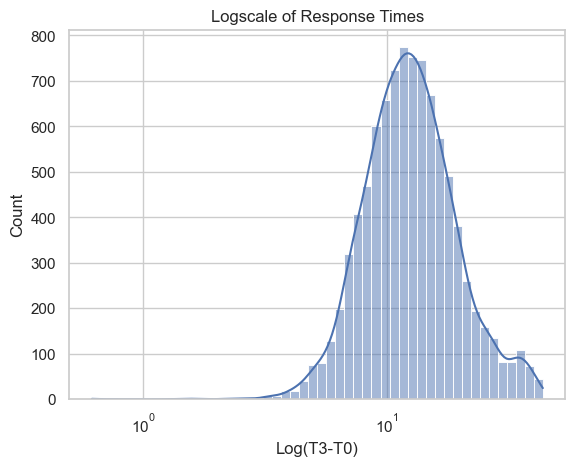

In [37]:
# Plot response times
sns.histplot(data=aed_ready['T3-T0'], bins=50, log_scale=True, kde=True).set(title='Logscale of Response Times', xlabel='Log(T3-T0)') 
# Right-skewed distribution, so log scale was used.

In [38]:
# Last check if no weird values are included in the dataset

# Get the minimum and maximum values of the 'latitude' column
min_latitude = aed_ready['Latitude'].min()
max_latitude = aed_ready['Latitude'].max()
# Get the minimum and maximum values of the 'longitude' column
min_longitude = aed_ready['Longitude'].min()
max_longitude = aed_ready['Longitude'].max()
# Get the minimum and maximum values of the response time column
min_timedelta = aed_ready['T3-T0'].min()
max_timedelta = aed_ready['T3-T0'].max()

print('Length of dataset: ', len(aed_ready))
print('Number of missing values per column: \n', print(aed_ready[['Latitude', 'Longitude', 'Intervention',
                                                                  'Eventlevel', 'T3-T0', 'EventType', 'AED', 
                                                                  'Ambulance', 'Mug']].isna().sum()))  # 1210 missing values for latitude from intervention dataset
print(f"Minimum latitude of dataset: {min_latitude}")
print(f"Maximum latitude of dataset: {max_latitude}")
print(f"Minimum longitude of dataset: {min_longitude}")
print(f"Maximum longitude of dataset: {max_longitude}")
print(f"min_timedelta of dataset: {min_timedelta}")  # Minimum outlier value = 44.27 minutes
print(f"max_timedelta of dataset: {max_timedelta}")  # Maximum outlier value = 80267.83 minutes

Length of dataset:  25529
Latitude            0
Longitude           0
Intervention        0
Eventlevel      14268
T3-T0           16233
EventType           0
AED                 0
Ambulance           0
Mug                 0
dtype: int64
Number of missing values per column: 
 None
Minimum latitude of dataset: 49.506818912808
Maximum latitude of dataset: 51.496268138986
Minimum longitude of dataset: 2.582286169092
Maximum longitude of dataset: 6.344506259237
min_timedelta of dataset: 0.6166666666666667
max_timedelta of dataset: 43.56666666666667


**Save new Dataset to GitHub**

In [39]:
# aed_ready.to_csv('Data/aed_placement_df.csv', index=False)